In [1]:
!pip install diffusers==0.24.0 transformers==4.36.2 torch==2.1.2 torchvision==0.16.2 accelerate==0.25.0 \
    opencv-python==4.8.1.78 matplotlib==3.8.2 tqdm==4.66.1 einops==0.7.0 huggingface_hub==0.19.4 opencv-python xformers requests pillow

  Using cached diffusers-0.24.0-py3-none-any.whl.metadata (18 kB)
  Using cached transformers-4.36.2-py3-none-any.whl.metadata (126 kB)
  Using cached torch-2.1.2-cp310-cp310-manylinux1_x86_64.whl.metadata (25 kB)
  Using cached torchvision-0.16.2-cp310-cp310-manylinux1_x86_64.whl.metadata (6.6 kB)
  Using cached accelerate-0.25.0-py3-none-any.whl.metadata (18 kB)
  Using cached opencv_python-4.8.1.78-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
  Using cached matplotlib-3.8.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached tqdm-4.66.1-py3-none-any.whl.metadata (57 kB)
  Using cached einops-0.7.0-py3-none-any.whl.metadata (13 kB)
  Using cached huggingface_hub-0.19.4-py3-none-any.whl.metadata (14 kB)
  Using cached xformers-0.0.29.post3-cp310-cp310-manylinux_2_28_x86_64.whl.metadata (1.0 kB)
  Using cached regex-2024.11.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (40 kB)
  Using cached sa

In [1]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.cuda.amp import autocast, GradScaler

from diffusers import AutoencoderKL, UNet2DConditionModel, DDPMScheduler, DDIMScheduler
from transformers import CLIPTextModel, CLIPTokenizer

import cubediff_visualize as viz

# First, import necessary libraries
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
from skimage.metrics import structural_similarity as ssim

import cv2
from cubediff_utils import * 
from cubediff_visualize import *

In [2]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Print the number of available GPUs
if torch.cuda.is_available():
    gpu_count = torch.cuda.device_count()
    print(f"Number of available GPUs: {gpu_count}")
    for i in range(gpu_count):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

Using device: cuda
Number of available GPUs: 1
GPU 0: NVIDIA L4


Successfully loaded image: (2571, 7227, 3)


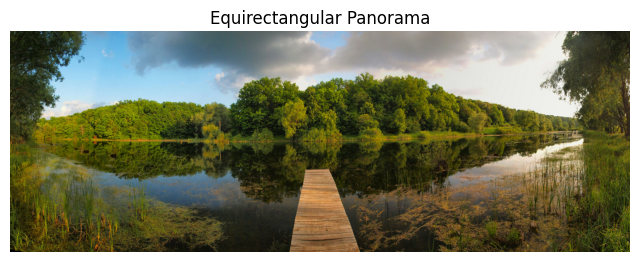

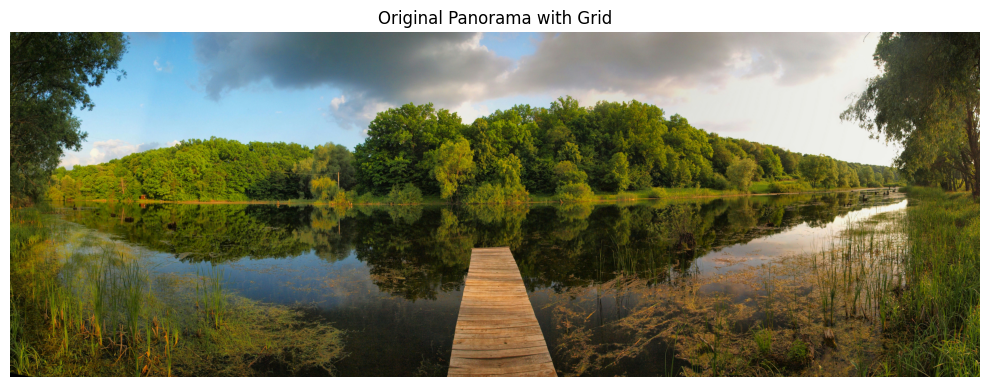

In [3]:
# Download a sample panorama image
# Sample URL - Use your own panorama image URL here
sample_url = None # "https://images.pexels.com/photos/1076885/pexels-photo-1076885.jpeg"

# Load the equirectangular panorama from URL
equirect_img = load_image_from_url(sample_url) if sample_url else None
local_file_path = "./panoramas/lake.jpg" # https://unsplash.com/photos/brown-wooden-dock-on-lake-surrounded-by-green-trees-during-daytime-GNNoZa8zVwY

# If URL loading fails, try loading local file
if equirect_img is None:
    equirect_img = load_local_image(local_file_path)

# If both methods fail, create a test image
if equirect_img is None:
    print("Creating a test image since loading failed")
    # Create a simple test image with a gradient pattern
    height, width = 512, 1024  # Standard equirectangular ratio is 1:2
    equirect_img = np.zeros((height, width, 3), dtype=np.uint8)
    
    # Create a simple pattern for testing
    for y in range(height):
        for x in range(width):
            # Horizontal gradient for R channel
            r = int(255 * x / width)
            # Vertical gradient for G channel
            g = int(255 * y / height)
            # Diagonal gradient for B channel
            b = int(255 * (x + y) / (width + height))
            equirect_img[y, x] = [r, g, b]
    
    print(f"Created test image: {equirect_img.shape}")

# Display the equirectangular panorama
plt.figure(figsize=(8, 4))
plt.imshow(equirect_img)
plt.title('Equirectangular Panorama')
plt.axis('off')
plt.show()

# Display with grid lines (optional)
visualize_equirectangular(equirect_img, "Original Panorama with Grid")

In [ ]:


# Then paste the functions above in your cubediff_utils.py file:
# - equirect_to_cubemap
# - cubemap_to_equirect
# - fix_equirect_seams
# - enhance_equirect_poles
# - fix_cubemap_edge_artifacts
# - convert_equirect_to_cubemap_and_back
# - calculate_metrics
# - diagnose_conversion_issues

# In your notebook, replace the code in cell [5] with:
# Convert to cubemap
face_size = 512  # You can adjust this based on your needs
print("Converting equirectangular to cubemap...")
cube_faces = equirect_to_cubemap(equirect_img, face_size=face_size)

print("Fixing edge artifacts...")
fixed_cube_faces = fix_cubemap_edge_artifacts(cube_faces)

print("Converting cubemap back to equirectangular...")
reconstructed_equirect = cubemap_to_equirect(
    fixed_cube_faces, 
    height=equirect_img.shape[0], 
    width=equirect_img.shape[1]
)

# Alternatively, use the wrapper function:
# reconstructed_equirect = convert_equirect_to_cubemap_and_back(equirect_img)

# In cell [10], add:
print("Calculating metrics...")
metrics = calculate_metrics(equirect_img, reconstructed_equirect)

print("Quality Metrics Summary:")
print(f"MSE: {metrics['mse']:.2f} (lower is better)")
print(f"PSNR: {metrics['psnr']:.2f} dB (higher is better, >30dB is good)")
print(f"SSIM: {metrics['ssim']:.4f} (closer to 1.0 is better)")
print(f"Percentage of pixels with low difference (<5): {metrics['low_diff_percentage']:.2f}%")
print(f"Percentage of pixels with medium difference (5-10): {metrics['medium_diff_percentage']:.2f}%")
print(f"Percentage of pixels with high difference (>10): {metrics['high_diff_percentage']:.2f}%")

# Add detailed diagnostics
diagnostic_results = diagnose_conversion_issues(equirect_img, reconstructed_equirect)
print("\nDetailed Conversion Diagnostics:")
print(f"Seam Difference: {diagnostic_results['Seam_Diff']:.2f}")
print(f"North Pole Difference: {diagnostic_results['North_Pole_Diff']:.2f}")
print(f"South Pole Difference: {diagnostic_results['South_Pole_Diff']:.2f}")
print(f"Equator Difference: {diagnostic_results['Equator_Diff']:.2f}")
print("\nLongitude Band Analysis:")
for region, diff in diagnostic_results['Longitude_Diffs'].items():
    print(f"{region}: {diff:.2f} average difference")
print("\nDiagnosed Issues:")
for i, issue in enumerate(diagnostic_results['Diagnoses']):
    print(f"{i+1}. {issue}")

Converting equirectangular to cubemap...
Fixing edge artifacts...
Converting cubemap back to equirectangular...
Calculating metrics...
